# Example for ACDSS model.

In [1]:
import sys
sys.path.append('..')

### Data preparation.

In [2]:
import pandas as pd

In [5]:
vars = ['stay_id', 'heart_rate', 'resp_rate', 'urineoutput_24hr', 'spo2', 'gcs', 'label']
df = pd.read_csv('../data/deterioration.csv', usecols=vars, index_col='stay_id')
mean = df.mean()
df = df.groupby('stay_id').ffill().fillna(mean)  # missing value imputation
df = 2 * (df - df.min()) / (df.max() - df.min()) - 1  # min-max scale to [-1, 1]
df

,heart_rate,resp_rate,spo2,urineoutput_24hr,gcs,label
stay_id,,,,,,
30000213,-0.159015,-0.307368,0.978947,-0.889724,0.866667,-1.0
30000213,-0.123180,-0.424931,0.924458,-0.409524,0.916667,-1.0
30000484,-0.037234,-0.487719,0.992157,-0.947870,-0.500000,-1.0
30000484,-0.060727,-0.515789,0.997059,-0.907769,0.111111,-1.0
30000484,-0.032358,-0.347368,0.998039,-0.773434,0.888889,-1.0
...,...,...,...,...,...,...
39999810,-0.300827,-0.440936,0.912418,-0.959900,0.875000,-1.0
39999810,-0.321924,-0.458124,0.940392,-0.879699,0.861111,-1.0
39999810,-0.354337,-0.503759,0.935747,-0.879699,0.916667,-1.0


### Fit the model.

In [ ]:
import os
import torch
from causal.discovery import ACDSS
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs('./checkpoints/', exist_ok=True)

In [ ]:
model = ACDSS(df.shape[1], n_hidden=256, n_edge_types=2).to(device)
model.fit(df, batch_size=128, max_epochs=10)

Epoch 10: 100%|██████████| 10/10 [07:41<00:00, 46.14s/it]


### Predict edge probabilities from the fitted model.

In [9]:
checkpoint = torch.load('./checkpoints/ACDSS.ckpt', map_location=device)
model = ACDSS(**checkpoint['hparams']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
edge_probs = model.predict(df, batch_size=128)
print(f'Shape of predicted edge probabilities: {edge_probs.shape}')

/var/folders/w4/2tjclkt51816ypgrqb08flg00000gn/T/ipykernel_82408/2591005203.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./checkpoints/ACDSS.

Shape of predicted edge probabilities: (50261, 6, 6)


### Visualize a predicted graph.

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [11]:
graph = edge_probs[0].T  # select the first simulation and transpose (receiver <- sender) graph to (sender -> receiver) graph.
graph = np.where(graph >= 0.5, graph, 0)  # set probability threshold to 0.5
graph = nx.DiGraph(graph)
pos = nx.shell_layout(graph)
weights = [graph[u][v]['weight'] for u, v in graph.edges()]

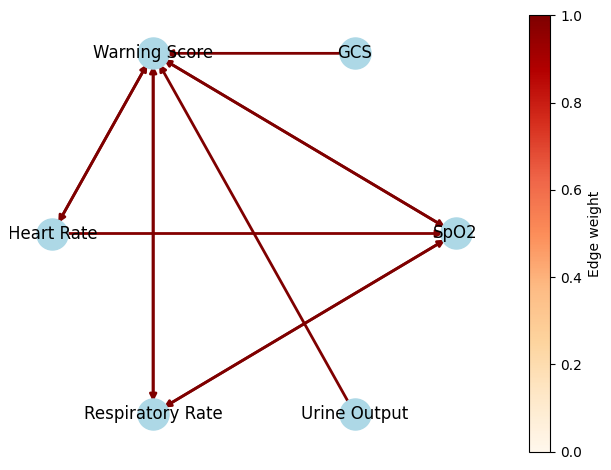

In [17]:
nx.draw_networkx_nodes(graph, pos, node_color='lightblue', node_size=500)  # skip stay_id
nx.draw_networkx_labels(graph, pos, labels={0: 'Heart Rate', 1: 'Respiratory Rate', 2: 'Urine Output', 3: 'SpO2', 4: 'GCS', 5: 'Warning Score'})
nx.draw_networkx_edges(graph, pos, edge_color=weights, edge_cmap=plt.cm.OrRd, edge_vmin=0, edge_vmax=1, width=2)
plt.colorbar(plt.cm.ScalarMappable(plt.Normalize(0, 1), plt.cm.OrRd), ax=plt.gca(), label='Edge weight')    
plt.axis('off')
plt.tight_layout()
plt.show()